In [14]:
import json
import re

In [15]:
label_mapping = {
    "The first.": "A",
    "The second.": "B",
    "The second is better.": "B",
    "The latter is better.": "B",
    "The latter.": "B",
}

In [16]:
output

{'id': ['/mnt/bn/audio-visual-llm-data3/wangsiyin/SALMONN/data/tmhint_zhi/wavs/6475_a.wav'],
 'ground_truth': ['The second.'],
 'loss': 0.3824641704559326,
 'acc': 1.0,
 'total': 4,
 'text': ['The second.</s>'],
 'prompt': ['USER: <Speech><SpeechHere></Speech> Could you please indicate which speech sample has better quality?\nASSISTANT:'],
 'task': ['mos_ABtest']}

In [17]:
path = "./eval_test_epoch_best_tmhint.json"
with open(path) as f:
    outputs = json.load(f)

count_all, count_correct, count_incorrect, count_tie, error = 0, 0, 0, 0, 0
predictions = []
error = 0
for i, output in enumerate(outputs):
    verdict_text = label_mapping[output['text'][0].strip("</s>")]
    gt = label_mapping[output['ground_truth'][0]]
    
    assert verdict_text in ['A', 'B', 'C', 'D']
    assert gt in ['A', 'B']
    
        
    if verdict_text == "A":
        if gt == "A":
            count_correct += 1
            evaluation = "correct"
        else:
            count_incorrect += 1
            evaluation = "incorrect"
    elif verdict_text == "B":
        if gt == "B":
            count_correct += 1
            evaluation = "correct"
        else:
            count_incorrect += 1
            evaluation = "incorrect"
    elif verdict_text == "C":
        count_tie += 1
        evaluation = 'tie'
    else:
        error += 1
        evaluation = 'error'
    count_all += 1
    predictions.append([evaluation, verdict_text])
print("total:", count_all)
print("correct:   {:.2f}%".format(count_correct/count_all*100))
print("incorrect: {:.2f}%".format(count_incorrect/count_all*100))
print("tie:       {:.2f}%".format(count_tie/count_all*100))
print("error:     {:.2f}%".format(error/count_all*100))


total: 6475
correct:   66.25%
incorrect: 33.75%
tie:       0.00%
error:     0.00%


# System-level Correlation

In [18]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

In [19]:
def analyze_correlation_and_plot(list_a, list_b):
    # 1. Compute Pearson correlation
    pearson_corr, _ = stats.pearsonr(list_a, list_b)

    # 2. Compute Spearman correlation
    spearman_corr, _ = stats.spearmanr(list_a, list_b)

    # Print results
    print(f"Pearson Correlation: {pearson_corr:.3f}")
    print(f"Spearman Correlation: {spearman_corr:.3f}")

    # 4. Scatter plot with best-fit line
    plt.figure(figsize=(5, 4))
    plt.scatter(list_a, list_b, color='blue', label='Data points')

    # Best fit line
    coefficients = np.polyfit(list_a, list_b, 1)  # Linear fit (degree=1)
    poly = np.poly1d(coefficients)
    best_fit_line = poly(list_a)

    plt.plot(list_a, best_fit_line, color='red', label='Best Fit Line')
    plt.xlabel('MOS (GT)')
    plt.ylabel('AudioJudge Prediction (Win Rate)')
    plt.title('Scatter Plot with Best Fit Line')
    plt.legend()
    plt.grid()
    plt.show()

In [26]:
audio_a

{'system': 'KLT_snr2_white',
 'row_id': 833,
 'text': '他的录取资格被取消了',
 'path': '/data/share/data/Speech/TMHINTQI/test/KLT_snr2_white_TMHINT_g4_22_05.wav',
 'Q': 3.0,
 'I': 8.666666666666666}

Pearson Correlation: 0.164
Spearman Correlation: 0.165


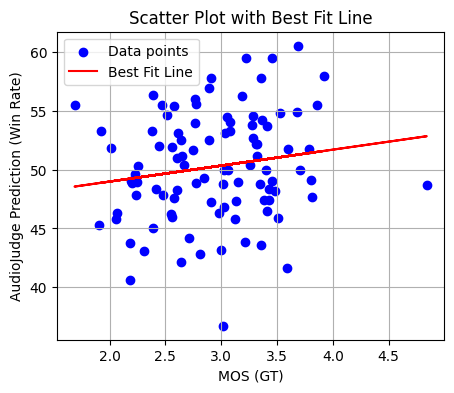

In [30]:
pred_by_system, gts_by_system = {}, {}

path = f"../experiments/tmhintqi/ab_testing/diffall_typhoon2_prompt2.processed.txt"
outputs = []
with open(path, "r") as f:
    for line in f:
        x = json.loads(line)
        outputs.append(x)

path = "./eval_test_epoch_best_tmhint.json"
with open(path) as f:
    outputsGOOD = json.load(f)
        
for output, output_good in zip(outputs, outputsGOOD):
    audio_a, audio_b = output['data']
    model_a = audio_a['system']
    model_b = audio_b['system']
    if model_a not in pred_by_system: pred_by_system[model_a] = []
    if model_a not in gts_by_system:  gts_by_system[model_a] = []
    if model_b not in pred_by_system: pred_by_system[model_b] = []
    if model_b not in gts_by_system:  gts_by_system[model_b] = []
        
    verdict_text = label_mapping[output_good['text'][0].strip("</s>")]
    assert verdict_text in ['A', 'B', 'C', 'D']
        
    if verdict_text == "A":
        pred_by_system[model_a] += [1]
        pred_by_system[model_b] += [0]
    elif verdict_text == "B":
        pred_by_system[model_a] += [0]
        pred_by_system[model_b] += [1]
    elif verdict_text == "C":
        pred_by_system[model_a] += [0.5]
        pred_by_system[model_b] += [0.5]    
    elif verdict_text == "D":
        pred_by_system[model_a] += [0.5]
        pred_by_system[model_b] += [0.5]    
    else:
        raise Exception()
        
    gts_by_system[model_a] += [audio_a['Q']]
    gts_by_system[model_b] += [audio_b['Q']]

system_level_pred, system_level_gts = [], []
systems = []
for system, pred in pred_by_system.items():
    gts = gts_by_system[system]
    assert len(pred) == len(gts)
    system_level_pred.append(np.mean(pred)*100)
    system_level_gts.append(np.mean(gts))
    systems.append(system)
analyze_correlation_and_plot(system_level_gts, system_level_pred)